Lets start with importing necessary libraries and read csv file of data
.

In [3]:
#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns   
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv("HouseListings-Top45Cities-10292023-kaggle.csv", encoding='latin1')


C:\Users\Yusuf\AppData\Local\Temp\ipykernel_14996\978049800.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


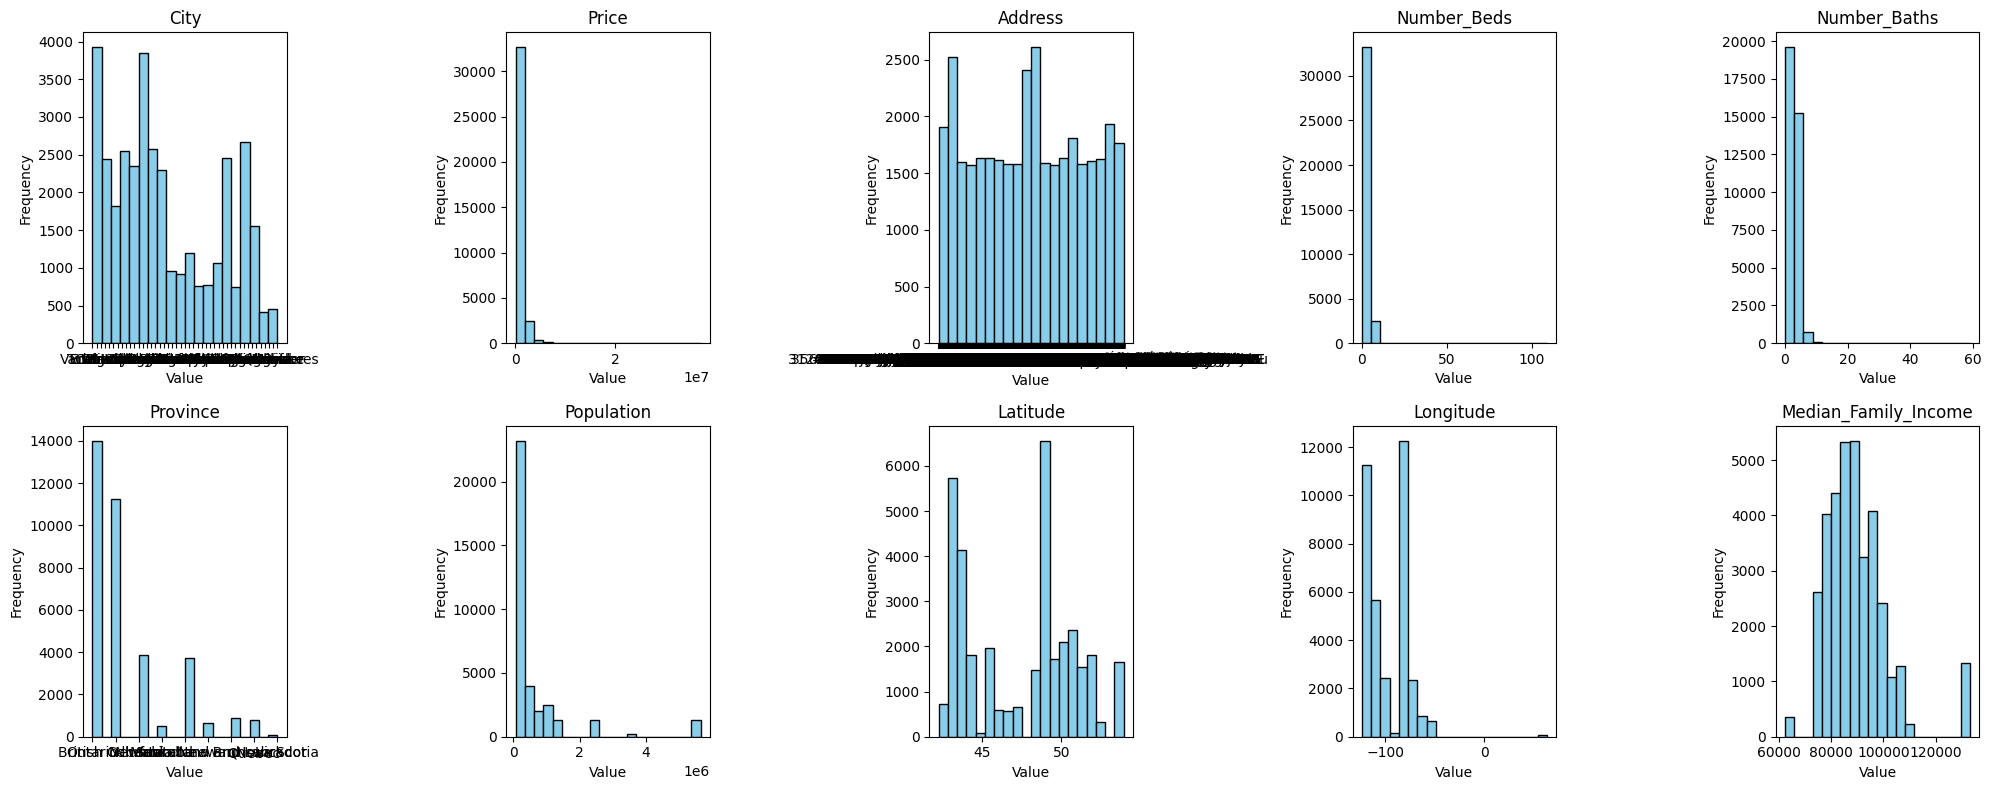

In [4]:
columns_to_plot = ['City', 'Price', 'Address', 'Number_Beds', 'Number_Baths',
                   'Province', 'Population', 'Latitude', 'Longitude', 'Median_Family_Income']

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.hist(data[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()

plt.show()

Handling unique and null values.

In [5]:
for col in data.columns:
    null_values_column = data[col].isnull().sum()
    print("Null values in column",col ,null_values_column)

for col in data.columns:
    unique_values_count = data[col].nunique()
    print("Unique values in column",col ,unique_values_count)
    if(unique_values_count > 15000):
        data.drop(columns=col,inplace=True)

Null values in column City 0
Null values in column Price 0
Null values in column Address 0
Null values in column Number_Beds 0
Null values in column Number_Baths 0
Null values in column Province 0
Null values in column Population 0
Null values in column Latitude 0
Null values in column Longitude 0
Null values in column Median_Family_Income 0
Unique values in column City 45
Unique values in column Price 4366
Unique values in column Address 31379
Unique values in column Number_Beds 31
Unique values in column Number_Baths 22
Unique values in column Province 9
Unique values in column Population 45
Unique values in column Latitude 45
Unique values in column Longitude 44
Unique values in column Median_Family_Income 32


Adding quadratic features and handling outliers.

In [6]:
data['Number_Beds2'] = data['Number_Beds']**2
data['Number_Baths2'] = data['Number_Baths']**2

numeric_cols = ['Price', 'Number_Beds', 'Number_Baths', 'Population', 'Latitude', 'Longitude', 'Median_Family_Income','Number_Beds2','Number_Baths2']

mask = pd.Series([True] * len(data))

for col in numeric_cols:
    mean = data[col].mean()
    std = data[col].std()
    
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    
    mask &= (data[col] >= lower_bound) & (data[col] <= upper_bound)

cleaned_data = data[mask]

data = cleaned_data



Encoding some columns.

In [7]:
mean = data.groupby('City')['Price'].mean()
data.loc[:, 'City'] = data['City'].map(mean)

label_encoder = LabelEncoder()
data['Province'] = label_encoder.fit_transform(data['Province'])


Implementing Z Score

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_columns = ['Number_Beds', 'Number_Baths','Population','Latitude','Longitude','Median_Family_Income','Price','City']  # Add more columns if needed

scaler = StandardScaler()

data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

Handling outlier part 2.

In [9]:
data = data[(data['Price'] < 3) & (data['Price'] > -3)]
data = data[(data['Number_Beds'] < 3) & (data['Number_Beds'] > -3)]
data = data[(data['Number_Baths'] < 3) & (data['Number_Baths'] > -3)]
data = data[(data['Population'] < 3) & (data['Population'] > -3)]
data = data[(data['Median_Family_Income'] < 3) & (data['Median_Family_Income'] > -3)]
data = data[(data['City'] < 3) & (data['City'] > -3)]

Multilinear Regression

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


features = data.drop(columns="Price")
target = data['Price']
Xtrain, Xtest, ytrain, y_test = train_test_split(features,target, test_size=0.2, shuffle=False)

model = LinearRegression()

model.fit(Xtrain,ytrain)

predictions = model.predict(Xtest)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)



Mean Squared Error: 0.36526027725872995
R2 Score: 0.5939728934521862
Mean Absolute Error: 0.400328000940093


KNN

In [11]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=20)
model.fit(Xtrain,ytrain)
predictions = model.predict(Xtest)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)




Mean Squared Error: 0.406455616145105
R2 Score: 0.5481797281596914
Mean Absolute Error: 0.43243228580287785


Random Forest Regression

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 40, 50]
}
model = RandomForestRegressor()
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(Xtrain, ytrain)
model = grid_search.best_estimator_

model.fit(Xtrain,ytrain)
predictions = model.predict(Xtest)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Mean Squared Error: 0.308069396806373
R2 Score: 0.6575468683866242
Mean Absolute Error: 0.3671467852386945


SVM Regression

In [13]:
from sklearn.svm import SVR
model = SVR(kernel='rbf')

model.fit(Xtrain,ytrain)
predictions = model.predict(Xtest)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)




Mean Squared Error: 0.3718986498630248
R2 Score: 0.5865936097235072
Mean Absolute Error: 0.38878530538848216


Gradient Regression

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

model = GradientBoostingRegressor(random_state=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(Xtrain, ytrain)

best_model = grid_search.best_estimator_

predictions = best_model.predict(Xtest)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)



Mean Squared Error: 0.3149058162090776
R2 Score: 0.6499474337860168
Mean Absolute Error: 0.3745621214576868


In [15]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', random_state=42)
model.fit(Xtrain, ytrain)

predictions = model.predict(Xtest)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)



Mean Squared Error: 0.3478953714731807
R2 Score: 0.6132759025406551
Mean Absolute Error: 0.3882366254473112
